<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Bike%20Sharing/Bike%20Sharing%20-%20Regression%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Sharing - Regression Example

This notebook demonstrates the **Universal ML Workflow** applied to a **regression problem** - predicting continuous numerical values instead of categories.

## Learning Objectives

By the end of this notebook, you will be able to:
- Apply neural networks to **regression** (predicting continuous values)
- Understand differences between regression and classification:
  - Output layer: Linear activation vs. Softmax/Sigmoid
  - Loss function: MSE/MAE vs. Cross-entropy
  - Metrics: MAE, RMSE, R² vs. Accuracy, Precision, Recall
- Handle mixed feature types for regression problems
- Evaluate regression models with appropriate metrics

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | [UCI Bike Sharing Dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) |
| **Problem Type** | Regression |
| **Target Variable** | `cnt` - Total bike rental count |
| **Data Type** | Structured (Mixed Categorical & Numerical) |
| **Features** | Weather, date/time, and environmental variables |

---

## Regression vs. Classification

| Aspect | Regression | Classification |
|--------|------------|----------------|
| **Output** | Continuous number (e.g., 542 bikes) | Category (e.g., "spam") |
| **Output Activation** | Linear (none) | Softmax/Sigmoid |
| **Loss Function** | MSE, MAE, Huber | Cross-entropy |
| **Metrics** | MAE, RMSE, R² | Accuracy, F1, AUC |

---

## 1. Defining the Problem and Assembling a Dataset

**Problem Statement:** Predict the total number of bike rentals for a given day based on weather and calendar features.

**Business Context:**
- Bike sharing companies need to plan bike distribution across stations
- Accurate demand prediction helps with maintenance scheduling
- Understanding demand drivers informs business strategy

## 2. Choosing a Measure of Success

**Regression Metrics:**

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **MAE** | Mean Absolute Error | Average prediction error in original units (bikes) |
| **RMSE** | Root Mean Squared Error | Penalizes large errors more heavily |
| **R²** | Coefficient of Determination | Proportion of variance explained (0 to 1) |

**We'll use MAE as primary metric** - it's interpretable ("on average, we're off by X bikes").

## 3. Deciding on an Evaluation Protocol

- **Hold-out Test Set (10%)**: Final evaluation
- **Validation Set**: Monitor training, early stopping
- **K-Fold Cross-Validation**: Hyperparameter tuning

**Note:** For regression, we don't use `stratify` - instead we shuffle randomly.

## 4. Preparing Your Data

### 4.1 Import Libraries

In [348]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [349]:
df = pd.read_csv('Bike Sharing.csv', sep=',')

df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [350]:
NUMERICAL_VARIABLES = ['temp', 'atemp', 'hum', 'windspeed']
CATEGORICAL_VARIABLES = ['season', 'holiday', 'weekday', 'workingday', 'weathersit']

In [351]:
features = df[NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES]

In [352]:
TARGET_VARIABLE = 'cnt'

target = df[TARGET_VARIABLE]

In [353]:
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, 
                                                    random_state=SEED, shuffle=True)

In [354]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_VARIABLES),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(X_train)

In [355]:
X_train, X_test = preprocessor.transform(X_train), preprocessor.transform(X_test)

In [356]:
y_train, y_test = y_train.values, y_test.values

In [357]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

## 5. Developing a Model That Does Better Than a Baseline

**Regression Baselines:**
- **Mean Baseline:** Always predict the mean of training data
- **Linear Model:** Simple linear regression as a sanity check

In [279]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2,
                        optimizer='rmsprop', loss='mean_squared_error',
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(1, 
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
    
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss)
    
    return model

In [280]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0), 
            'history': history }

In [281]:
INPUT_DIMENSION = X_train.shape[1]

LEARNING_RATE = 1
LOSS_FUNC = 'mean_squared_error'

In [282]:
slp_model = deep_neural_network(hidden_layers=0, 
                                input_dimension=INPUT_DIMENSION,
                                optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), 
                                loss=LOSS_FUNC, 
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 1)                 23        
                                                                 
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [283]:
batch_size = 64
EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [284]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [285]:
print('Mean Squared Error (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'], baseline))

Mean Squared Error (Validation): 1763527.38 (baseline=3755292.65)


In [286]:
def plot_training_history(history, monitor='loss') :
    
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
        monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)]) 
                              
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    
    _ = plt.show()

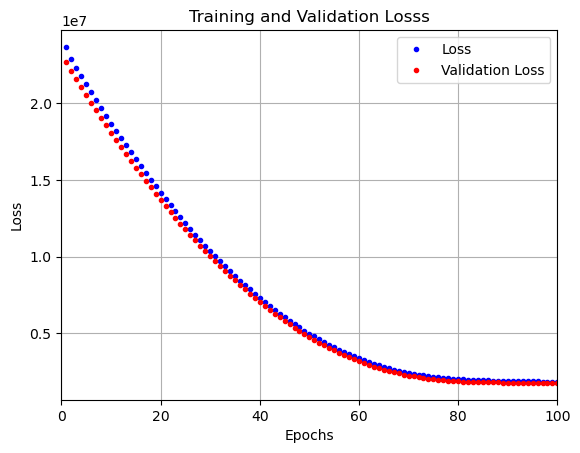

In [287]:
plot_training_history(trained_slp_model['history'], monitor='loss')

 ## Scaling up: developing a model that overfits

In [288]:
LEARNING_RATE = 0.01
EPOCHS = 200

mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=32,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION,
                                optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), 
                                loss=LOSS_FUNC, 
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 32)                736       
                                                                 
 dense_68 (Dense)            (None, 1)                 33        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [289]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

## 6. Scaling Up: Developing a Model That Overfits

Adding hidden layers to capture non-linear relationships between features and bike demand.

In [291]:
print('Mean Squared Error (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'], baseline))

Mean Squared Error (Validation): 1784016.38 (baseline=3755292.65)


 ## Regularizing your model and tuning your hyperparameters

In [292]:
# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [293]:
# Grid Search CV
def grid_search_cv(X, y, 
                   space, cv, 
                   learning_rate, loss, 
                   epochs, callbacks=[], seed=0,
                   addon_metrics={}, order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = KFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), 
                                        loss=loss)
           
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate]), 
                                                callbacks=callbacks, seed=seed) 
            
                        
            scores.append( trained['model'].evaluate(X[validate,:], y[validate], verbose=0) )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [302]:
KFOLDS = 5
LEARNING_RATE = 0.01
EPOCHS = 500

## 7. Regularizing Your Model and Tuning Hyperparameters

Using dropout and grid search to prevent overfitting and find optimal architecture.

In [305]:
stats.sort_values(by=['val_loss'], ascending=True).head(10)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss
112,2,64,relu,0.4,32,19.0,1703542.825
98,2,32,relu,0.2,32,25.8,1713956.575
111,2,64,relu,0.3,32,17.4,1714042.500
108,2,64,relu,0.0,32,18.0,1714385.500
113,2,64,relu,0.5,32,19.4,1714585.525
109,2,64,relu,0.1,32,18.6,1714814.050
110,2,64,relu,0.2,32,19.8,1720142.275
96,2,32,relu,0.0,32,23.2,1720225.275
97,2,32,relu,0.1,32,22.8,1721112.175
99,2,32,relu,0.3,32,25.6,1721563.675


In [339]:
LEARNING_RATE = 0.01
EPOCHS = 200

opt_model = deep_neural_network(hidden_layers=2, hidden_neurons=64,
                                dropout=0.4, activation='relu',
                                input_dimension=INPUT_DIMENSION,
                                optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), 
                                loss=LOSS_FUNC,
                                name='Deep_Wide_Network')

opt_model.summary()

Model: "Deep_Wide_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1650 (Dense)          (None, 64)                1472      
                                                                 
 dropout_948 (Dropout)       (None, 64)                0         
                                                                 
 dense_1651 (Dense)          (None, 64)                4160      
                                                                 
 dropout_949 (Dropout)       (None, 64)                0         
                                                                 
 dense_1652 (Dense)          (None, 1)                 65        
                                                                 
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


In [340]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

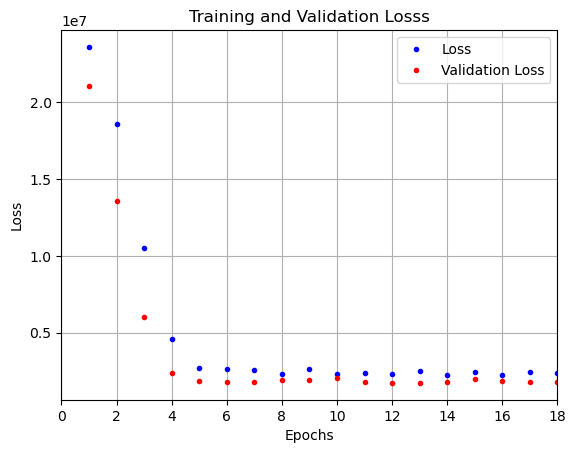

In [341]:
plot_training_history(trained_opt_model['history'], monitor='loss')

In [342]:
print('Mean Squared Error (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'], baseline))

Mean Squared Error (Validation): 1739096.62 (baseline=3755292.65)


In [346]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Mean Squared Error (Validation): {:.2f} (baseline={:.2f})'.format(mean_squared_error(y_test, preds), baseline))

Mean Squared Error (Validation): 1344316.74 (baseline=3755292.65)


---

## 8. Key Takeaways

1. **Regression Output:** Linear activation allows any real number output
2. **Loss:** MSE/MAE instead of cross-entropy  
3. **Metrics:** MAE interpretable; R² shows variance explained